In [1]:
#setting the path of our working directory
%cd C:/Users/HP/MINOR_2/data

C:\Users\HP\MINOR_2\data


In [ ]:
#import zipfile

In [ ]:
#with zipfile.ZipFile('C:/Users/shree/0last/words.zip', 'r') as zip_ref:
#        zip_ref.extractall('C:/Users/shree/0last/data')

In [2]:
#reading the first 50 lines of the file words
with open('C:/Users/HP/MINOR_2/data/words.txt','r') as f:
    for i in range(50):
        line = f.readline()
        print(line)

#--- words.txt ---------------------------------------------------------------#

#

# iam database word information

#

# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

#

#     a01-000u-00-00  -> word id for line 00 in form a01-000u

#     ok              -> result of word segmentation

#                            ok: word was correctly

#                            er: segmentation of word can be bad

#

#     154             -> graylevel to binarize the line containing this word

#     1               -> number of components for this word

#     408 768 27 51   -> bounding box around this word in x,y,w,h format

#     AT              -> the grammatical tag for this word, see the

#                        file tagset.txt for an explanation

#     A               -> the transcription for this word

#

a01-000u-00-00 ok 154 408 768 27 51 AT A

a01-000u-00-01 ok 154 507 766 213 48 NN MOVE

a01-000u-00-02 ok 154 796 764 70 50 TO to

a01-000u-00-03 ok 154 919 757 166 78 VB stop

a01

In [3]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup #used for preprocessing
from tensorflow import keras #importing keras, library through which our deep model bulids and runs

import matplotlib.pyplot as plt #used for vizualizations 
import tensorflow as tf #importing tensorflow, used for ml model
import numpy as np #arrays dealing 
import os #dealing with operating systems 

np.random.seed(42) #random seed generated is same everytime code is run
tf.random.set_seed(42) #random seed is set to be 42

In [4]:
#here we are ignoreing the comments and error entries and are storing the words in a new list and then shuffling them.
base_path = "C:/Users/HP/MINOR_2/data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [5]:
#words_list is splitted into three parts training, validation and test.
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

#used to cross check if the samples are equal to as calculated 
assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples

)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [6]:
base_image_path = os.path.join(base_path, "words")

#function defined for getting path for images and their labels and here it is called three times
def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [7]:
# Find maximum length and the size of the vocabulary in the training data.
#cleaning the first 10 labels to check wether this processing is happening properly or not

train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [8]:
#cleaned test label and validation label
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [10]:
#resizing of the image and then adding required padding to the image 

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [11]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

# reads an image file given by its path, decodes it, resizes it to a specified size (32x128 by default)
#without distorting the aspect ratio of the original image, converts it to a float tensor with pixel values
#normalized between 0 and 1, and returns the resulting tensor.
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

#converting sequence to integers
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

#image and label ki dictinaory we are getting 
def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

#we get the processed dataset
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [12]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

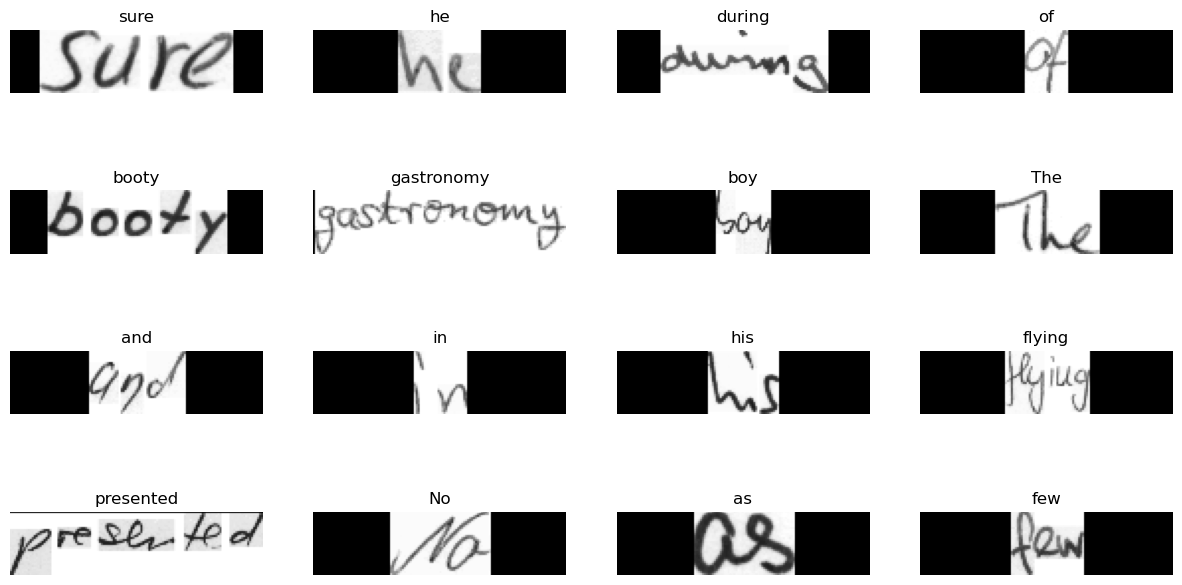

In [13]:


for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [14]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [15]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [16]:
# model training

In [ ]:
"""
epochs = 12  # To get good results this should be at least 50.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("handwriting.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',restore_best_weights=True)

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb,early_stopping_cb,edit_distance_callback],
)
"""

In [17]:
#Not running the above code as we have already traine the model before, thus commenting it out.
#here below we have called our model as .h5 file
import tensorflow as tf
from tensorflow.keras.layers import Layer
#(CTC) layer which is commonly used in Optical Character Recognition (OCR) tasks.
#The CTC layer computes the loss between the predicted and true labels while taking
#into account the possibility of misalignments between them.
# Define the CTCLayer as a custom layer
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

# Load the model with the custom CTCLayer
with tf.keras.utils.custom_object_scope({'CTCLayer': CTCLayer}):
    new_model = tf.keras.models.load_model('C:/Users/HP/MINOR_2/handwriting.h5')

# Show the model architecture
new_model.summary()


Model: "digitizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 128, 32, 128  36992       ['Conv1[0][0]']                  
                                )                                                                 
                                                                                          

In [18]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

len is :  2
batch img shape:  (128, 32, 1)
2/2 [==============================] - 8s 2s/step
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)


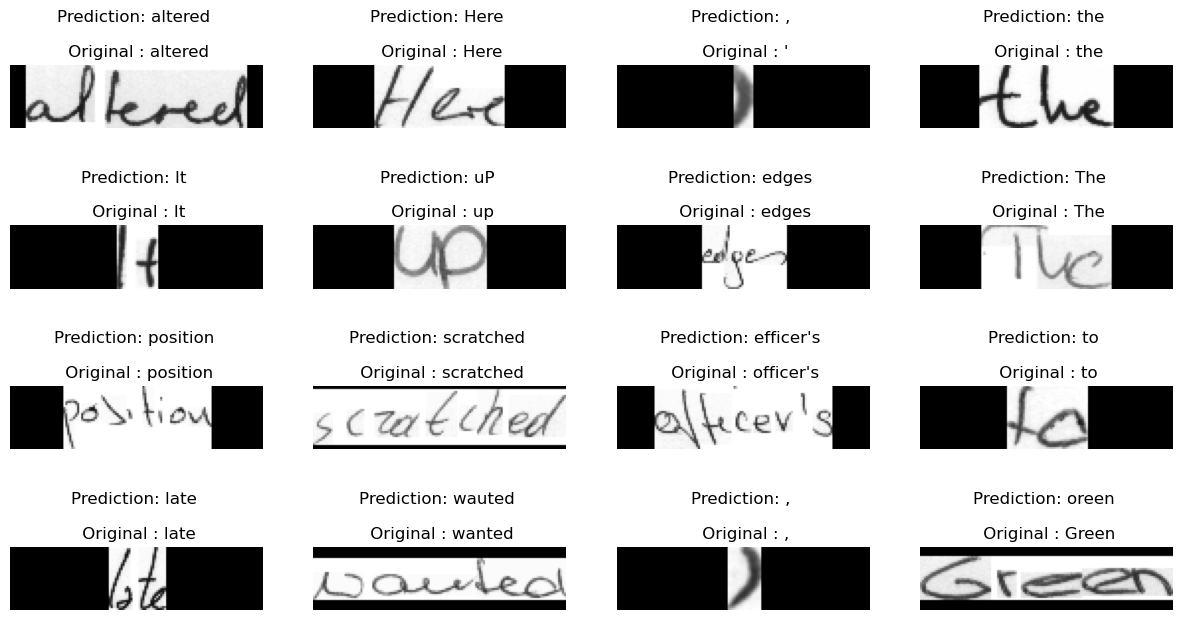

In [19]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    # print(batch["label"])
    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[1].shape)
    # print(batch)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        print(img.shape)
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()


In [ ]:
# Precision
"""
total_count = 0
correct_count = 0

for batch in test_ds.take(75):
    batch_images,batch_labels = batch["image"],batch["label"]

    
    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)

    for i in range(64):
        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")


        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        total_count = total_count+1
        if(label == pred_texts[i]):
          correct_count = correct_count+1 


print("Total count : ",total_count)

print("Correct count : ",correct_count)

percentage = (correct_count/total_count)*100
print(f"Percentage : {percentage}% .")
"""

In [20]:

def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [ ]:
"""
img_paths_3 = ["C:/Users/shree/0last/newimg.png","C:/Users/shree/0last/sampleimg2.png","C:/Users/shree/0last/sampleimg3.png","C:/Users/shree/0last/sampleimg4.png","C:/Users/shree/0last/sampleimg5.png"]
custom_ds = prepare_dataset_custom(img_paths_3)
custom_ds
"""

In [ ]:
"""
for batch in custom_ds.take(1):
    MAX_LABEL_LENGTH=21
    batch_images = tf.stack(batch)
    batch_labels = tf.zeros([batch_images.shape[0], MAX_LABEL_LENGTH])
    
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[0].shape)
    
    _, ax = plt.subplots(1, 5, figsize=(15, 8))

    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)
    
    
    print(pred_texts)

    for i in range(5):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")

plt.show()
"""

In [ ]:
"""
custom_ds = prepare_dataset_custom(output_image_paths)
custom_ds
"""

In [ ]:
"""
for batch in custom_ds.take(1):
    MAX_LABEL_LENGTH=21
    batch_images = tf.stack(batch)
    batch_labels = tf.zeros([batch_images.shape[0], MAX_LABEL_LENGTH])
    
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[0].shape)
    
    _, ax = plt.subplots(len(batch), 1, figsize=(30, 30))

    preds = new_model.predict([batch_images, batch_labels])
    pred_texts = decode_batch_predictions(preds)
    
    
    print(pred_texts)

        
    for i in range(len(batch)):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")



plt.show()
"""

In [23]:
!streamlit run FRONTEND_FINALFILE.py


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: FRONTEND_FINALFILE.py
